In [2]:
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torchvision import datasets
transformation=transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize((0.1307),(0.3081))]
)
train_dataset=datasets.MNIST('data/',train=True,transform=transformation,download=True)
test_dataset=datasets.MNIST('data/',train=False,transform=transformation,download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 99963240.23it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 24188437.27it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31806122.16it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17804232.49it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
train_loader=DataLoader(train_dataset,shuffle=True,batch_size=32)
test_loader=DataLoader(test_dataset,shuffle=True,batch_size=32)

In [24]:
import matplotlib.pyplot as plt
def plot_img(img):
  image=img.numpy()[0]
  mean=0.1307
  std=0.3081
  image=((mean*image)+std)
  plt.imshow(image,cmap='gray')

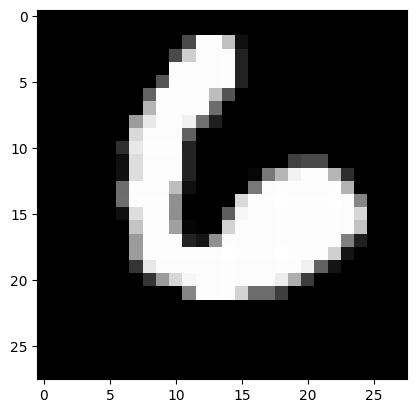

In [25]:
sample_data=next(iter(train_loader))
plot_img(sample_data[0][1])


In [22]:
sample_data[0][1].numpy()[0].shape

(28, 28)

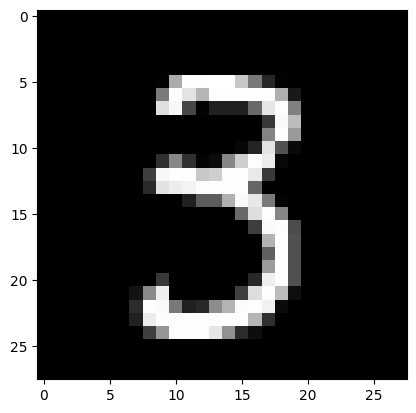

In [23]:
plot_img(sample_data[0][2])

In [78]:
#build a model
from torch import nn
import torch.nn.functional as F
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.conv1=nn.Conv2d(1,6,5)
    self.conv2=nn.Conv2d(6,10,3)
    self.pool=nn.MaxPool2d(2,2)
    self.drop=nn.Dropout2d()
    self.fc1=nn.Linear(250,50)
    self.fc2=nn.Linear(50,10)


  def forward(self,x):
    x=F.relu(self.pool(self.conv1(x)))
    x=F.relu(self.pool(self.conv2(x)))
    #print(x.shape) #10*5*5
    x=x.view(-1,250)
    x=F.relu(self.fc1(x))
    x=self.drop(x)
    x=F.log_softmax(self.fc2(x),dim=1)
    return x

In [79]:
model=Net()
device='cuda' if torch.cuda.is_available() else "cpu"
if torch.cuda.is_available():
  model.to(device)
from torch.optim import SGD
optimizer=SGD(model.parameters(),lr=2.e-3,momentum=0.9)


In [94]:
import torch
criterion = nn.CrossEntropyLoss().cuda()

def fit(epoch,model,data_loader,phase='training',volatile=False):
  if phase=='training':
    model.train()
  else:
    model.eval()
    volatile=True
  running_loss=0
  running_corrects=0

  for batch_idx,(data,target) in enumerate(data_loader):
    if torch.cuda.is_available():
      data,target=data.to(device),target.to(device)
    #data,target=torch.Tensor(data,volatile),torch.Tensor(target,volatile)
    if phase=='training':
      optimizer.zero_grad()
    output=model(data)
    loss=criterion(output,target)
    if phase=='training':
      loss.backward()
      optimizer.step()
    running_loss+=loss.data*data.size(0)
    preds=output.data.max(dim=1,keepdim=True)[1]
    running_corrects += torch.sum(preds == target.data)
    running_loss=running_loss/len(data_loader.dataset)
    running_corrects += torch.sum(preds == target.data)

  epoch_loss = running_loss / len(data_loader)
  epoch_acc = (running_corrects / len(data_loader))
  print(f"{phase} loss {epoch_loss : {5}.{2}} and {phase} accuracy : {epoch_acc :{10}.{4}}")
  return epoch_loss,epoch_acc


In [95]:
from tqdm import tqdm
train_loss,train_accuracy=[],[]
val_loss,val_accuracy=[],[]
for epoch in tqdm(range(1,20)):
  epoch_loss,epoch_accuracy=fit(epoch,model,train_loader,phase='training')
  val_epoch_loss,val_epoch_accuracy=fit(epoch,model,test_loader,phase='validation')
  train_loss.append(epoch_loss)
  train_accuracy.append(epoch_accuracy)
  val_loss.append(val_epoch_loss)
  val_loss.append(val_epoch_accuracy)

  0%|          | 0/19 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


training loss  1.2e-08 and training accuracy :      260.9


  5%|▌         | 1/19 [00:17<05:23, 18.00s/it]

validation loss  8.6e-08 and validation accuracy :      260.2
training loss  1.4e-08 and training accuracy :      260.1


 11%|█         | 2/19 [00:38<05:26, 19.23s/it]

validation loss  1.1e-08 and validation accuracy :      262.7
training loss  1.6e-09 and training accuracy :      261.7


 16%|█▌        | 3/19 [00:56<05:01, 18.86s/it]

validation loss  1.3e-08 and validation accuracy :      259.8
training loss  4.3e-08 and training accuracy :      261.2


 21%|██        | 4/19 [01:14<04:38, 18.57s/it]

validation loss  1.6e-09 and validation accuracy :      263.1
training loss  7e-08 and training accuracy :      261.1


 26%|██▋       | 5/19 [01:33<04:20, 18.58s/it]

validation loss  8.7e-09 and validation accuracy :      261.3
training loss  1.2e-07 and training accuracy :      260.7


 32%|███▏      | 6/19 [01:51<04:00, 18.47s/it]

validation loss  7.2e-09 and validation accuracy :      264.5
training loss  2.9e-08 and training accuracy :      261.6


 37%|███▋      | 7/19 [02:10<03:44, 18.75s/it]

validation loss  6.6e-08 and validation accuracy :      261.7
training loss  1.1e-08 and training accuracy :      261.5


 42%|████▏     | 8/19 [02:29<03:24, 18.64s/it]

validation loss  1.1e-09 and validation accuracy :      261.3
training loss  2.7e-08 and training accuracy :      262.0


 47%|████▋     | 9/19 [02:48<03:07, 18.74s/it]

validation loss  3e-09 and validation accuracy :      261.5
training loss  2e-08 and training accuracy :      262.2


 53%|█████▎    | 10/19 [03:06<02:46, 18.51s/it]

validation loss  3.1e-09 and validation accuracy :      259.2
training loss  8.3e-09 and training accuracy :      262.2


 58%|█████▊    | 11/19 [03:24<02:28, 18.58s/it]

validation loss  7.2e-09 and validation accuracy :      264.5
training loss  5.9e-08 and training accuracy :      260.5


 63%|██████▎   | 12/19 [03:43<02:09, 18.53s/it]

validation loss  1.5e-07 and validation accuracy :      264.2
training loss  2.1e-08 and training accuracy :      260.6


 68%|██████▊   | 13/19 [04:02<01:52, 18.75s/it]

validation loss  5.1e-10 and validation accuracy :      262.6
training loss  5.2e-08 and training accuracy :      261.7


 74%|███████▎  | 14/19 [04:20<01:32, 18.58s/it]

validation loss  1.3e-09 and validation accuracy :      262.9
training loss  4.7e-08 and training accuracy :      261.5


 79%|███████▉  | 15/19 [04:41<01:17, 19.26s/it]

validation loss  7.3e-09 and validation accuracy :      262.8
training loss  5.5e-09 and training accuracy :      262.1


 84%|████████▍ | 16/19 [05:01<00:58, 19.36s/it]

validation loss  2.4e-09 and validation accuracy :      258.7
training loss  2.9e-09 and training accuracy :      261.2


 89%|████████▉ | 17/19 [05:23<00:40, 20.23s/it]

validation loss  1.7e-06 and validation accuracy :      260.5
training loss  2.2e-09 and training accuracy :      261.7


 95%|█████████▍| 18/19 [05:41<00:19, 19.65s/it]

validation loss  1.9e-08 and validation accuracy :      260.9
training loss  5.4e-08 and training accuracy :      261.5


100%|██████████| 19/19 [06:00<00:00, 18.98s/it]

validation loss  6.4e-07 and validation accuracy :      260.8


In [96]:
#saving model
torch.save(model, 'mnist_model.pth')
loaded_model=torch.load('mnist_model.pth')

In [97]:
loaded_model

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=250, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [136]:
single_loaded_img = test_loader.dataset.data[0]
single_loaded_img = single_loaded_img.to(device)
single_loaded_img = single_loaded_img[None, None]
single_loaded_img = single_loaded_img.type('torch.cuda.FloatTensor') # instead of DoubleTensor
single_loaded_img.shape

torch.Size([1, 1, 28, 28])

In [120]:
single_loaded_img.squeeze().shape

torch.Size([28, 28])

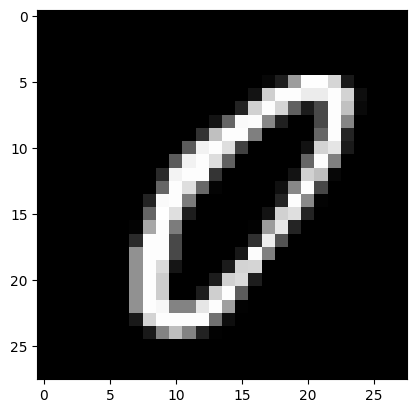

In [126]:
sample_data=next(iter(test_loader))
plot_img(sample_data[0][2])

In [141]:
out_predict = model(single_loaded_img).to(device)
print(out_predict)
pred = out_predict.max(1, keepdim=True)[1] #pred_value = out_predict.cpu().data.numpy().argmax()
print(pred)

tensor([[-2627.7256, -1714.1125, -1854.2777, -1590.2399, -2155.2537, -2643.6914,
         -3377.0044,     0.0000, -2135.2573, -1741.1409]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)
tensor([[7]], device='cuda:0')


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


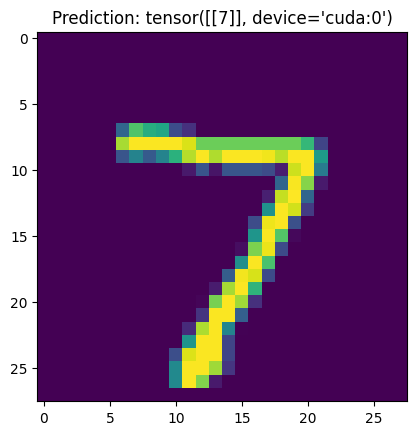

In [146]:
# Display the input image and predictions
plt.imshow(single_loaded_img.cpu().squeeze())
plt.title(f'Prediction: {pred}')
plt.show()